In [213]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

In [214]:
# Stop warnings
import warnings as w
w.simplefilter(action='ignore',category=FutureWarning)

# **1. CGT Dataset Exploration**
---

## **1.1. Read CGT Data**
---

In [215]:
cgt_DF_original = pd.read_csv('cgt/consolidated.csv',delimiter=';')
cgt_DF_original

,dataset,id,property,property_holds,chain,addr,contractname,fp_sol,fp_sol2,fp_bytecode,fp_runtime,swc,dasp
0,CodeSmells,0x00430f32b8e77a456d0ab7e6f1dc1b84f4ae62e0,Unchecked External Call,f,main,0x00430f32b8e77a456d0ab7e6f1dc1b84f4ae62e0,MyToken,7391ec54eca9eb37bd2cd1d7263097a6,3aac43ff5e5b48296ec58d5dee7d108d,eb5bcd53f30ce45e455f445819c4dfd1,bbb54fe73d18f1fbbb51bc0c3920e9cd,104.0,4.0
1,CodeSmells,0x00430f32b8e77a456d0ab7e6f1dc1b84f4ae62e0,Dos Under external influence,f,main,0x00430f32b8e77a456d0ab7e6f1dc1b84f4ae62e0,MyToken,7391ec54eca9eb37bd2cd1d7263097a6,3aac43ff5e5b48296ec58d5dee7d108d,eb5bcd53f30ce45e455f445819c4dfd1,bbb54fe73d18f1fbbb51bc0c3920e9cd,113.0,5.0
2,CodeSmells,0x00430f32b8e77a456d0ab7e6f1dc1b84f4ae62e0,strict balance equality,f,main,0x00430f32b8e77a456d0ab7e6f1dc1b84f4ae62e0,MyToken,7391ec54eca9eb37bd2cd1d7263097a6,3aac43ff5e5b48296ec58d5dee7d108d,eb5bcd53f30ce45e455f445819c4dfd1,bbb54fe73d18f1fbbb51bc0c3920e9cd,132.0,NaN
3,CodeSmells,0x00430f32b8e77a456d0ab7e6f1dc1b84f4ae62e0,Unmatched type assignment,f,main,0x00430f32b8e77a456d0ab7e6f1dc1b84f4ae62e0,MyToken,7391ec54eca9eb37bd2cd1d7263097a6,3aac43ff5e5b48296ec58d5dee7d108d,eb5bcd53f30ce45e455f445819c4dfd1,bbb54fe73d18f1fbbb51bc0c3920e9cd,NaN,NaN
4,CodeSmells,0x00430f32b8e77a456d0ab7e6f1dc1b84f4ae62e0,Transaction state Dependency,f,main,0x00430f32b8e77a456d0ab7e6f1dc1b84f4ae62e0,MyToken,7391ec54eca9eb37bd2cd1d7263097a6,3aac43ff5e5b48296ec58d5dee7d108d,eb5bcd53f30ce45e455f445819c4dfd1,bbb54fe73d18f1fbbb51bc0c3920e9cd,115.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20450,eThor,0xfe9c69945687539fabbf531133838d9cce522a76,reentrancy,f,main,0xfe9c69945687539fabbf531133838d9cce522a76,NaN,NaN,NaN,6e7c7db087b6df28af12f3911a4dfa1f,90f72e7120351a8752a8da30397aa35e,107.0,1.0
20451,eThor,0xfeeb8a968f0d7fd58e29fbfc525051f50ee2fedc,reentrancy,t,main,0xfeeb8a968f0d7fd58e29fbfc525051f50ee2fedc,Etheramid2,ab0e2ea9e14512594f714bc485a94361,ab0e2ea9e14512594f714bc485a94361,c99576c2b5ff3122d1100b204c1eb340,af2737edbd91a12f977d2f62512ef1ad,107.0,1.0
20452,eThor,0xff3216f86a723f2c23b03b5cd1f622eb1a204159,reentrancy,f,main,0xff3216f86a723f2c23b03b5cd1f622eb1a204159,ValentineRegistry,d2c9f4ddb6dabb91742838a31da15421,61fa6ad7678fa97cd094f14068ac4086,ff4afc0652f28856516ae18bcc004dc1,5482fbfa676268aadadd59d02aa94a2a,107.0,1.0
20453,eThor,0xff821e51150dea3ca4d201d0df4e568dc9e03239,reentrancy,f,main,0xff821e51150dea3ca4d201d0df4e568dc9e03239,NaN,NaN,NaN,ca3d8fbb2ea49f93810b316a855cc450,bf5269b022133280187cc3100be46985,107.0,1.0


## **1.2. Edit SWC to DASP Mapping (Round #1)**
---

In [216]:
Map = pd.read_excel('../Mapping/VulnerablityMap.xlsx',sheet_name='CGT_Update')

In [217]:
DS = Map['DS'].unique().tolist()
SWC_DASP_Map_Dic = {}
for i in range(0, len(DS)):
    DS[i] = DS[i][1:]
    SWC_DASP_Map_Dic[DS[i]] = {}

for index, row in Map.iterrows():
    set = Map.at[index,'DS'].encode("ascii", "ignore").decode()
    Property = Map.at[index,'Property'].encode("ascii", "ignore").decode()
    
    SWC = Map.at[index,'SWC']
    DASP = Map.at[index,'DASP']

    SWC_DASP_Map_Dic[set][Property] =[SWC,DASP]
    
SWC_DASP_Map_Dic

{'CodeSmells': {'Block Info Dependency': [120.0, 6],
  'Compiler Version not fixed': [103.0, 10],
  'Deprecated APIs': [0.0, 10],
  'Dos Under external influence': [113.0, 5],
  'Greedy Contract': [132.0, 5],
  'Hard Code Address': [0.0, 10],
  'High Gas Consumption Data Type': [0.0, 10],
  'High Gas Consumption Function Type': [0.0, 10],
  'Misleading Data Location': [0.0, 10],
  'Missing Interrupter': [0.0, 10],
  'Missing Reminder': [0.0, 10],
  'Missing Return statement': [0.0, 10],
  'Nest Call': [128.0, 5],
  'Reentrancy': [107.0, 1],
  'strict balance equality': [132.0, 5],
  'Transaction state Dependency': [115.0, 2],
  'Unchecked External Call': [104.0, 4],
  'Unmatched ERC-20 standard': [0.0, 10],
  'Unmatched type assignment': [0.0, 10],
  'Unused statement': [135.0, 10]},
 'ContractFuzzer': {'delegatecall_dangerous': [112.0, 2],
  'exception_disorder': [104.0, 4],
  'freezing_ether': [132.0, 5],
  'gasless_send': [134.0, 5],
  'numberdependency': [120.0, 6],
  'reentrancy':

In [218]:
cgt_DF_Edited = cgt_DF_original
for index, row in cgt_DF_Edited.iterrows():
    if cgt_DF_Edited.at[index,'property_holds'] == 't':
        
        dataset = cgt_DF_Edited.at[index,'dataset']
        property = cgt_DF_Edited.at[index,'property']
        
        cgt_DF_Edited.at[index,'swc'] = SWC_DASP_Map_Dic[dataset][property][0] 
        cgt_DF_Edited.at[index,'dasp'] = SWC_DASP_Map_Dic[dataset][property][1]
    else:
        continue
cgt_DF_Edited

,dataset,id,property,property_holds,chain,addr,contractname,fp_sol,fp_sol2,fp_bytecode,fp_runtime,swc,dasp
0,CodeSmells,0x00430f32b8e77a456d0ab7e6f1dc1b84f4ae62e0,Unchecked External Call,f,main,0x00430f32b8e77a456d0ab7e6f1dc1b84f4ae62e0,MyToken,7391ec54eca9eb37bd2cd1d7263097a6,3aac43ff5e5b48296ec58d5dee7d108d,eb5bcd53f30ce45e455f445819c4dfd1,bbb54fe73d18f1fbbb51bc0c3920e9cd,104.0,4.0
1,CodeSmells,0x00430f32b8e77a456d0ab7e6f1dc1b84f4ae62e0,Dos Under external influence,f,main,0x00430f32b8e77a456d0ab7e6f1dc1b84f4ae62e0,MyToken,7391ec54eca9eb37bd2cd1d7263097a6,3aac43ff5e5b48296ec58d5dee7d108d,eb5bcd53f30ce45e455f445819c4dfd1,bbb54fe73d18f1fbbb51bc0c3920e9cd,113.0,5.0
2,CodeSmells,0x00430f32b8e77a456d0ab7e6f1dc1b84f4ae62e0,strict balance equality,f,main,0x00430f32b8e77a456d0ab7e6f1dc1b84f4ae62e0,MyToken,7391ec54eca9eb37bd2cd1d7263097a6,3aac43ff5e5b48296ec58d5dee7d108d,eb5bcd53f30ce45e455f445819c4dfd1,bbb54fe73d18f1fbbb51bc0c3920e9cd,132.0,NaN
3,CodeSmells,0x00430f32b8e77a456d0ab7e6f1dc1b84f4ae62e0,Unmatched type assignment,f,main,0x00430f32b8e77a456d0ab7e6f1dc1b84f4ae62e0,MyToken,7391ec54eca9eb37bd2cd1d7263097a6,3aac43ff5e5b48296ec58d5dee7d108d,eb5bcd53f30ce45e455f445819c4dfd1,bbb54fe73d18f1fbbb51bc0c3920e9cd,NaN,NaN
4,CodeSmells,0x00430f32b8e77a456d0ab7e6f1dc1b84f4ae62e0,Transaction state Dependency,f,main,0x00430f32b8e77a456d0ab7e6f1dc1b84f4ae62e0,MyToken,7391ec54eca9eb37bd2cd1d7263097a6,3aac43ff5e5b48296ec58d5dee7d108d,eb5bcd53f30ce45e455f445819c4dfd1,bbb54fe73d18f1fbbb51bc0c3920e9cd,115.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20450,eThor,0xfe9c69945687539fabbf531133838d9cce522a76,reentrancy,f,main,0xfe9c69945687539fabbf531133838d9cce522a76,NaN,NaN,NaN,6e7c7db087b6df28af12f3911a4dfa1f,90f72e7120351a8752a8da30397aa35e,107.0,1.0
20451,eThor,0xfeeb8a968f0d7fd58e29fbfc525051f50ee2fedc,reentrancy,t,main,0xfeeb8a968f0d7fd58e29fbfc525051f50ee2fedc,Etheramid2,ab0e2ea9e14512594f714bc485a94361,ab0e2ea9e14512594f714bc485a94361,c99576c2b5ff3122d1100b204c1eb340,af2737edbd91a12f977d2f62512ef1ad,107.0,1.0
20452,eThor,0xff3216f86a723f2c23b03b5cd1f622eb1a204159,reentrancy,f,main,0xff3216f86a723f2c23b03b5cd1f622eb1a204159,ValentineRegistry,d2c9f4ddb6dabb91742838a31da15421,61fa6ad7678fa97cd094f14068ac4086,ff4afc0652f28856516ae18bcc004dc1,5482fbfa676268aadadd59d02aa94a2a,107.0,1.0
20453,eThor,0xff821e51150dea3ca4d201d0df4e568dc9e03239,reentrancy,f,main,0xff821e51150dea3ca4d201d0df4e568dc9e03239,NaN,NaN,NaN,ca3d8fbb2ea49f93810b316a855cc450,bf5269b022133280187cc3100be46985,107.0,1.0


## **1.3. CGT Dataset Exploration**
---

In [219]:
slectedDSs = ['JiuZhou','NotSoSmartC','SBcurated','SolidiFI','SWCregistry','eThor','Doublade']

cgt_DF = cgt_DF_Edited.loc[cgt_DF_Edited['dataset'].isin(slectedDSs)]
cgt_DF.reset_index(drop=True,inplace=True)
cgt_DF

,dataset,id,property,property_holds,chain,addr,contractname,fp_sol,fp_sol2,fp_bytecode,fp_runtime,swc,dasp
0,SolidiFI,Overflow-Underflow-3,Overflow-Underflow,t,NaN,NaN,CareerOnToken,e01ab8b006611d8612a81724edcfdc02,cd722241b984e03c3b3e7d44e5d89fab,NaN,NaN,101.0,3.0
1,SolidiFI,Overflow-Underflow-30,Overflow-Underflow,t,NaN,NaN,SKYBITToken,acb72f1f3b2898b62d6d841f999e5c77,60946c853b87744818818b7d1104bc14,NaN,NaN,101.0,3.0
2,SBcurated,mishandled,unchecked_low_level_calls,t,NaN,NaN,SendBack,914172cd9a4220f4edd2f53ac1c140fe,082ce59d6dba073019f173269fa5528b,NaN,NaN,104.0,4.0
3,JiuZhou,byte[],byte[],t,NaN,NaN,waste2,f4f5521d8231f09f5145a06c6e55315f,8543063fd919912a246f4f6b47cd4d63,0cd787a372debb6be2de3694e7f08dae,d32c7fd90819ed857bcbea2a1a194011,NaN,10.0
4,SolidiFI,Overflow-Underflow-31,Overflow-Underflow,t,NaN,NaN,FeeTransactionManager,e42f79800a4c6a1bf6fded5cf76c5b5e,6ffd35a74e52932c9ce280caa7d7287c,NaN,NaN,101.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1760,eThor,0xfe9c69945687539fabbf531133838d9cce522a76,reentrancy,f,main,0xfe9c69945687539fabbf531133838d9cce522a76,NaN,NaN,NaN,6e7c7db087b6df28af12f3911a4dfa1f,90f72e7120351a8752a8da30397aa35e,107.0,1.0
1761,eThor,0xfeeb8a968f0d7fd58e29fbfc525051f50ee2fedc,reentrancy,t,main,0xfeeb8a968f0d7fd58e29fbfc525051f50ee2fedc,Etheramid2,ab0e2ea9e14512594f714bc485a94361,ab0e2ea9e14512594f714bc485a94361,c99576c2b5ff3122d1100b204c1eb340,af2737edbd91a12f977d2f62512ef1ad,107.0,1.0
1762,eThor,0xff3216f86a723f2c23b03b5cd1f622eb1a204159,reentrancy,f,main,0xff3216f86a723f2c23b03b5cd1f622eb1a204159,ValentineRegistry,d2c9f4ddb6dabb91742838a31da15421,61fa6ad7678fa97cd094f14068ac4086,ff4afc0652f28856516ae18bcc004dc1,5482fbfa676268aadadd59d02aa94a2a,107.0,1.0
1763,eThor,0xff821e51150dea3ca4d201d0df4e568dc9e03239,reentrancy,f,main,0xff821e51150dea3ca4d201d0df4e568dc9e03239,NaN,NaN,NaN,ca3d8fbb2ea49f93810b316a855cc450,bf5269b022133280187cc3100be46985,107.0,1.0


In [220]:
print('No. of samples with NaN address: ', len(cgt_DF) - cgt_DF['addr'].count())

No. of samples with NaN address:  786


In [9]:
#Remove negative rows ##### optional..I did not perform it#######
cgt_DF.drop(cgt_DF[cgt_DF.property_holds == 'f'].index,inplace=True)
cgt_DF.reset_index(inplace=True, drop=True)
cgt_DF

/var/folders/9f/l2zc5y5j5zdg_clh6fyts20r0000gn/T/ipykernel_18845/2804571670.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cgt_DF.drop(cgt_DF[cgt_DF.property_holds == 'f'].index,inplace=True)


,dataset,id,property,property_holds,chain,addr,contractname,fp_sol,fp_sol2,fp_bytecode,fp_runtime,swc,dasp
0,SolidiFI,Overflow-Underflow-3,Overflow-Underflow,t,NaN,NaN,CareerOnToken,e01ab8b006611d8612a81724edcfdc02,cd722241b984e03c3b3e7d44e5d89fab,NaN,NaN,101.0,3.0
1,SolidiFI,Overflow-Underflow-30,Overflow-Underflow,t,NaN,NaN,SKYBITToken,acb72f1f3b2898b62d6d841f999e5c77,60946c853b87744818818b7d1104bc14,NaN,NaN,101.0,3.0
2,SBcurated,mishandled,unchecked_low_level_calls,t,NaN,NaN,SendBack,914172cd9a4220f4edd2f53ac1c140fe,082ce59d6dba073019f173269fa5528b,NaN,NaN,104.0,4.0
3,JiuZhou,byte[],byte[],t,NaN,NaN,waste2,f4f5521d8231f09f5145a06c6e55315f,8543063fd919912a246f4f6b47cd4d63,0cd787a372debb6be2de3694e7f08dae,d32c7fd90819ed857bcbea2a1a194011,NaN,10.0
4,SolidiFI,Overflow-Underflow-31,Overflow-Underflow,t,NaN,NaN,FeeTransactionManager,e42f79800a4c6a1bf6fded5cf76c5b5e,6ffd35a74e52932c9ce280caa7d7287c,NaN,NaN,101.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,eThor,0xfac50f760d114de38bf0a6d44f31a9c22f778db3,reentrancy,t,main,0xfac50f760d114de38bf0a6d44f31a9c22f778db3,Investment,0aef6c211111272d7254889fc692314e,ff38f6ffc05dd86deb233efbf1be30e5,f69219171b270300bf33c3ebb0831973,6a1f98a39bac67f81a98bdfaab14518b,107.0,1.0
948,eThor,0xfcaf204852781b57c23023aa28f21437f7303505,reentrancy,t,main,0xfcaf204852781b57c23023aa28f21437f7303505,NaN,NaN,NaN,2d18bec73bf1d4e7430b34d81aa19dc2,87639c3c5c8b372d5fad93cd277d74f0,107.0,1.0
949,eThor,0xfd981838c1cc9b534b938c56b1c2123bdc700a32,reentrancy,t,main,0xfd981838c1cc9b534b938c56b1c2123bdc700a32,NaN,NaN,NaN,d21fe1375299820512eb80f426c8bcd7,5531d8806a3a4216bda0a78716a5adc5,107.0,1.0
950,eThor,0xfeeb8a968f0d7fd58e29fbfc525051f50ee2fedc,reentrancy,t,main,0xfeeb8a968f0d7fd58e29fbfc525051f50ee2fedc,Etheramid2,ab0e2ea9e14512594f714bc485a94361,ab0e2ea9e14512594f714bc485a94361,c99576c2b5ff3122d1100b204c1eb340,af2737edbd91a12f977d2f62512ef1ad,107.0,1.0


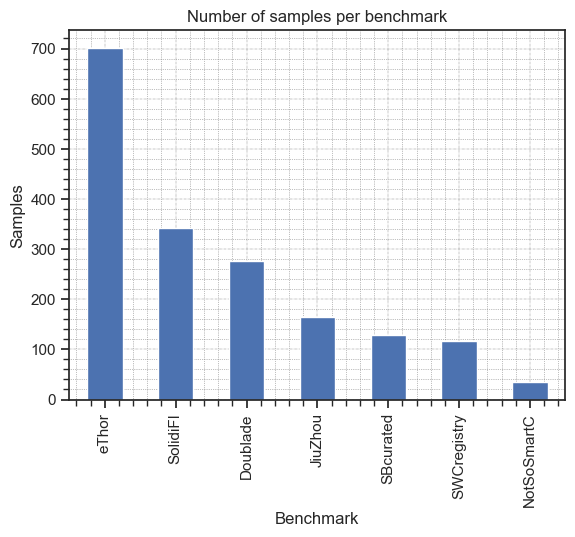

In [221]:
ax = cgt_DF['dataset'].value_counts().plot(kind='bar',title="Number of samples per benchmark")
ax.set_xlabel("Benchmark")
ax.set_ylabel("Samples")
plt.grid(True, color = "grey", which='major', linewidth = "0.3", linestyle = "-.")
plt.grid(True, color="grey", which='minor', linestyle=':', linewidth="0.5");
plt.minorticks_on()
plt.show()

In [222]:
print('%d publicly available benchmarks are included in this dataset. \n The benchmarks are: \n %s' %(len(cgt_DF['dataset'].unique()), cgt_DF['dataset'].unique().tolist()))

7 publicly available benchmarks are included in this dataset. 
 The benchmarks are: 
 ['SolidiFI', 'SBcurated', 'JiuZhou', 'Doublade', 'SWCregistry', 'NotSoSmartC', 'eThor']


In [223]:
print('%d properties in the CGT data, which are:\n %s' %(len(cgt_DF['property'].unique()), cgt_DF['property'].unique().tolist()))

119 properties in the CGT data, which are:
 ['Overflow-Underflow', 'unchecked_low_level_calls', 'byte[]', 'reentrancy', 'Right-To-Left-Overridecontrolcharacter (U+202E)', 'Timestamp-Dependency', 'Unchecked-Send', 'Locked money', 'lowlevelcall_result', 'Write the wrong constructor name', 'unexpectedrevert_result', 'Re-entrancy', 'Implicit visibility level', 'Complex fallback function', 'Integer signedness', 'Unhandled-Exceptions', 'selfdestruct_result', 'tx_result', 'Any type of specified function variable', 'DOS by gaslimit', 'Storage overlap attack', 'The call address or data are externally controlled', 'Improper use of assert', 'Improper use of require', 'Forced accept ethers', 'Invariant in loop', 'Randomness affected by miners', 'Incorrect inheritance order', 'Txorigin for authentication', 'Removes dynamic array elements', 'Use deprecated built-in symbols', 'continue in do-while', 'tx.origin', 'DOS by non-existent address or contract', 'Non-public variables are accessed by public o

In [224]:
print('%d SWC codes in the CGT data, which are:\n %s' %(len(cgt_DF['swc'].unique()), cgt_DF['swc'].unique().tolist()))

40 SWC codes in the CGT data, which are:
 [101.0, 104.0, nan, 107.0, 130.0, 116.0, 997.0, 118.0, 113.0, 108.0, 999.0, 132.0, 115.0, 127.0, 128.0, 124.0, 112.0, 110.0, 123.0, 120.0, 125.0, 111.0, 136.0, 114.0, 105.0, 117.0, 996.0, 119.0, 995.0, 106.0, 103.0, 133.0, 109.0, 129.0, 122.0, 135.0, 134.0, 131.0, 102.0, 100.0]


In [225]:
print('%d DASP ranks in the CGT data, which are:\n %s' %(len(cgt_DF['dasp'].unique()), cgt_DF['dasp'].unique().tolist()))

11 DASP ranks in the CGT data, which are:
 [3.0, 4.0, 10.0, 1.0, nan, 8.0, 2.0, 5.0, 6.0, 7.0, 9.0]


# **2. Convert CGT DS into Multi-Label DS**
---

In [226]:
#Remove label columns
cgt_MultiDS = cgt_DF.drop(['property','property_holds','swc','dasp'],axis=1)
# Remove duplicate ids
cgt_MultiDS = cgt_MultiDS.drop_duplicates('fp_sol',keep='first',ignore_index=True)
cgt_MultiDS.dropna(subset=["fp_sol"], inplace=True)
cgt_MultiDS.reset_index(inplace=True, drop=True)
cgt_MultiDS

,dataset,id,chain,addr,contractname,fp_sol,fp_sol2,fp_bytecode,fp_runtime
0,SolidiFI,Overflow-Underflow-3,NaN,NaN,CareerOnToken,e01ab8b006611d8612a81724edcfdc02,cd722241b984e03c3b3e7d44e5d89fab,NaN,NaN
1,SolidiFI,Overflow-Underflow-30,NaN,NaN,SKYBITToken,acb72f1f3b2898b62d6d841f999e5c77,60946c853b87744818818b7d1104bc14,NaN,NaN
2,SBcurated,mishandled,NaN,NaN,SendBack,914172cd9a4220f4edd2f53ac1c140fe,082ce59d6dba073019f173269fa5528b,NaN,NaN
3,JiuZhou,byte[],NaN,NaN,waste2,f4f5521d8231f09f5145a06c6e55315f,8543063fd919912a246f4f6b47cd4d63,0cd787a372debb6be2de3694e7f08dae,d32c7fd90819ed857bcbea2a1a194011
4,SolidiFI,Overflow-Underflow-31,NaN,NaN,FeeTransactionManager,e42f79800a4c6a1bf6fded5cf76c5b5e,6ffd35a74e52932c9ce280caa7d7287c,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1562,eThor,0xfe3672eff595cfd36ed05aaf4622d1aec3b5e852,main,0xfe3672eff595cfd36ed05aaf4622d1aec3b5e852,FastRealisticPyramid,58e72e153b767b33fa73f3bec1735760,58e72e153b767b33fa73f3bec1735760,af5efee798317c93fd6b4347dd5ef790,e3d793154f77295015f0ec1f321ef3fb
1563,eThor,0xfe70f7d0fe6ceb71d4fc0308322ffa6098043e43,main,0xfe70f7d0fe6ceb71d4fc0308322ffa6098043e43,ERW,cdb8ca9da6bb4dc0c63586e46f503234,cdb8ca9da6bb4dc0c63586e46f503234,b1a9c764aeab033349a91833227ddf46,e1d9861f0b7b402e59e5d4002135173b
1564,eThor,0xfeeb8a968f0d7fd58e29fbfc525051f50ee2fedc,main,0xfeeb8a968f0d7fd58e29fbfc525051f50ee2fedc,Etheramid2,ab0e2ea9e14512594f714bc485a94361,ab0e2ea9e14512594f714bc485a94361,c99576c2b5ff3122d1100b204c1eb340,af2737edbd91a12f977d2f62512ef1ad
1565,eThor,0xff3216f86a723f2c23b03b5cd1f622eb1a204159,main,0xff3216f86a723f2c23b03b5cd1f622eb1a204159,ValentineRegistry,d2c9f4ddb6dabb91742838a31da15421,61fa6ad7678fa97cd094f14068ac4086,ff4afc0652f28856516ae18bcc004dc1,5482fbfa676268aadadd59d02aa94a2a


## **2.1. Two mult-label columns: SWC and DASP**
---

In [227]:
#Add two mult-label columns: SWC and DASP
cgt_MultiDS['property']= ''
cgt_MultiDS['SWC']=''
cgt_MultiDS['DASP']= ''

In [228]:
#Option #1 This can be used if the DS contain negative rows
for index, row in cgt_MultiDS.iterrows():
    #extract rows for a specific contract (id)
    subDF = cgt_DF[cgt_DF['fp_sol'] == row['fp_sol']]
    #Remove negative rows
    subDF.drop(subDF[subDF.property_holds == 'f'].index,inplace=True)
    subDF.reset_index(inplace=True, drop=True)

    #Remove None values
    SWC= subDF['swc'].unique().tolist()
    SWC = [int(x) for x in SWC if not math.isnan(x)]
    DASP = subDF['dasp'].unique().tolist()
    DASP = [int(x) for x in DASP if not math.isnan(x)]
    property = subDF['property'].unique().tolist()
    #property = [int(x) for x in property if not math.isnan(x)]
    #Set values of label columns
    cgt_MultiDS.at[index,'SWC'] = sorted(SWC)
    cgt_MultiDS.at[index,'DASP'] = sorted(DASP)
    cgt_MultiDS.at[index,'property'] = sorted(property)

cgt_MultiDS.to_csv('./EDA_Outcomes/mult-label_CGT_DS_with_NegativeSamples.csv',index=False)

/var/folders/9f/l2zc5y5j5zdg_clh6fyts20r0000gn/T/ipykernel_18845/1688604059.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subDF.drop(subDF[subDF.property_holds == 'f'].index,inplace=True)


In [155]:
#Option #2 This can be used if the negative rows are deleted from DS
for index, row in cgt_MultiDS.iterrows():
    #extract rows for a specific contract (id)
    subDF = cgt_DF[cgt_DF['fp_sol'] == row['fp_sol']]
    #Remove None values
    SWC= subDF['swc'].unique().tolist()
    SWC = [int(x) for x in SWC if not math.isnan(x)]
    DASP = subDF['dasp'].unique().tolist()
    DASP = [int(x) for x in DASP if not math.isnan(x)]
    property = subDF['property'].unique().tolist()
    #property = [int(x) for x in property if not math.isnan(x)]
    #Set values of label columns
    cgt_MultiDS.at[index,'SWC'] = sorted(SWC)
    cgt_MultiDS.at[index,'DASP'] = sorted(DASP)
    cgt_MultiDS.at[index,'property'] = sorted(property)

cgt_MultiDS.to_csv('./EDA_Outcomes/mult-label_CGT_DS.csv',index=False)

In [230]:
cgt_MultiDS

,dataset,id,chain,addr,contractname,fp_sol,fp_sol2,fp_bytecode,fp_runtime,property,SWC,DASP
0,SolidiFI,Overflow-Underflow-3,NaN,NaN,CareerOnToken,e01ab8b006611d8612a81724edcfdc02,cd722241b984e03c3b3e7d44e5d89fab,NaN,NaN,[Overflow-Underflow],[101],[3]
1,SolidiFI,Overflow-Underflow-30,NaN,NaN,SKYBITToken,acb72f1f3b2898b62d6d841f999e5c77,60946c853b87744818818b7d1104bc14,NaN,NaN,[Overflow-Underflow],[101],[3]
2,SBcurated,mishandled,NaN,NaN,SendBack,914172cd9a4220f4edd2f53ac1c140fe,082ce59d6dba073019f173269fa5528b,NaN,NaN,[unchecked_low_level_calls],[104],[4]
3,JiuZhou,byte[],NaN,NaN,waste2,f4f5521d8231f09f5145a06c6e55315f,8543063fd919912a246f4f6b47cd4d63,0cd787a372debb6be2de3694e7f08dae,d32c7fd90819ed857bcbea2a1a194011,[byte[]],[],[10]
4,SolidiFI,Overflow-Underflow-31,NaN,NaN,FeeTransactionManager,e42f79800a4c6a1bf6fded5cf76c5b5e,6ffd35a74e52932c9ce280caa7d7287c,NaN,NaN,[Overflow-Underflow],[101],[3]
...,...,...,...,...,...,...,...,...,...,...,...,...
1562,eThor,0xfe3672eff595cfd36ed05aaf4622d1aec3b5e852,main,0xfe3672eff595cfd36ed05aaf4622d1aec3b5e852,FastRealisticPyramid,58e72e153b767b33fa73f3bec1735760,58e72e153b767b33fa73f3bec1735760,af5efee798317c93fd6b4347dd5ef790,e3d793154f77295015f0ec1f321ef3fb,[],[],[]
1563,eThor,0xfe70f7d0fe6ceb71d4fc0308322ffa6098043e43,main,0xfe70f7d0fe6ceb71d4fc0308322ffa6098043e43,ERW,cdb8ca9da6bb4dc0c63586e46f503234,cdb8ca9da6bb4dc0c63586e46f503234,b1a9c764aeab033349a91833227ddf46,e1d9861f0b7b402e59e5d4002135173b,[],[],[]
1564,eThor,0xfeeb8a968f0d7fd58e29fbfc525051f50ee2fedc,main,0xfeeb8a968f0d7fd58e29fbfc525051f50ee2fedc,Etheramid2,ab0e2ea9e14512594f714bc485a94361,ab0e2ea9e14512594f714bc485a94361,c99576c2b5ff3122d1100b204c1eb340,af2737edbd91a12f977d2f62512ef1ad,[reentrancy],[107],[1]
1565,eThor,0xff3216f86a723f2c23b03b5cd1f622eb1a204159,main,0xff3216f86a723f2c23b03b5cd1f622eb1a204159,ValentineRegistry,d2c9f4ddb6dabb91742838a31da15421,61fa6ad7678fa97cd094f14068ac4086,ff4afc0652f28856516ae18bcc004dc1,5482fbfa676268aadadd59d02aa94a2a,[],[],[]


## **2.2. SWC Labeled Data**
---

In [231]:
cgt_MultiDS_SWC = pd.DataFrame(columns=['fp_sol','100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '123', '124', '125', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '995', '996', '997', '999'])

for index, row in cgt_MultiDS.iterrows():
    cgt_MultiDS_SWC.at[index,'fp_sol'] = row['fp_sol']
    for code in row['SWC']:
        cgt_MultiDS_SWC.at[index,str(code)] = 1
cgt_MultiDS_SWC.fillna(0, inplace=True)
cgt_MultiDS_SWC.to_csv('./EDA_Outcomes/cgt_MultiDS_SWC_.csv',index=False)

In [232]:
cgt_MultiDS_SWC

,fp_sol,100,101,102,103,104,105,106,107,108,...,132,133,134,135,136,995,996,997,999,122
0,e01ab8b006611d8612a81724edcfdc02,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,acb72f1f3b2898b62d6d841f999e5c77,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,914172cd9a4220f4edd2f53ac1c140fe,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,f4f5521d8231f09f5145a06c6e55315f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,e42f79800a4c6a1bf6fded5cf76c5b5e,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,58e72e153b767b33fa73f3bec1735760,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1563,cdb8ca9da6bb4dc0c63586e46f503234,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1564,ab0e2ea9e14512594f714bc485a94361,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.0
1565,d2c9f4ddb6dabb91742838a31da15421,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


## **2.3. DASP Labeled Data**
---

In [233]:
cgt_MultiDS_DASP = pd.DataFrame(columns=['fp_sol','1','2','3','4','5','6','7','8','9','10'])

for index, row in cgt_MultiDS.iterrows():
    cgt_MultiDS_DASP.at[index,'fp_sol'] = row['fp_sol']
    for code in row['DASP']:
        cgt_MultiDS_DASP.at[index,str(code)] = 1
cgt_MultiDS_DASP.fillna(0, inplace=True)

cgt_MultiDS_DASP.to_csv('./EDA_Outcomes/cgt_MultiDS_DASP.csv',index=False)

In [234]:
cgt_MultiDS_DASP

,fp_sol,1,2,3,4,5,6,7,8,9,10
0,e01ab8b006611d8612a81724edcfdc02,0,0,1,0,0,0,0,0,0,0
1,acb72f1f3b2898b62d6d841f999e5c77,0,0,1,0,0,0,0,0,0,0
2,914172cd9a4220f4edd2f53ac1c140fe,0,0,0,1,0,0,0,0,0,0
3,f4f5521d8231f09f5145a06c6e55315f,0,0,0,0,0,0,0,0,0,1
4,e42f79800a4c6a1bf6fded5cf76c5b5e,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1562,58e72e153b767b33fa73f3bec1735760,0,0,0,0,0,0,0,0,0,0
1563,cdb8ca9da6bb4dc0c63586e46f503234,0,0,0,0,0,0,0,0,0,0
1564,ab0e2ea9e14512594f714bc485a94361,1,0,0,0,0,0,0,0,0,0
1565,d2c9f4ddb6dabb91742838a31da15421,0,0,0,0,0,0,0,0,0,0


# **3. Data Visualization**
---

## **3.1. Actual Number of Samples**
---

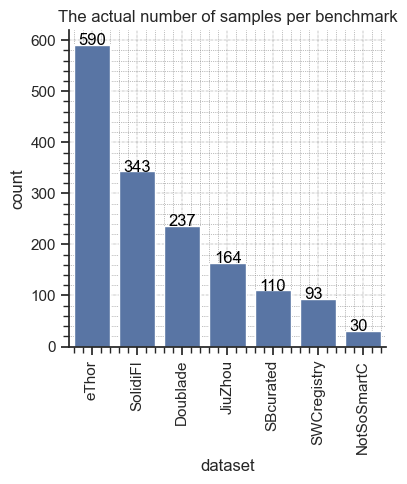

In [235]:
sns.set(style='ticks')
#create grouped bar chart

g=sns.catplot(x='dataset', y='count', data=pd.DataFrame(data=cgt_MultiDS['dataset'].value_counts()), kind='bar', height=4, aspect=1)

ax.set_xlabel("Benchmark")
ax.set_ylabel("Samples")

ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.1,
            p.get_height()* 1 ,
            '{0:.0f}'.format(p.get_height()),
            color='black',  size='medium')
    
plt.title('The actual number of samples per benchmark', fontsize=12)
plt.grid(True, color = "grey", which='major', linewidth = "0.3", linestyle = "-.")
plt.grid(True, color="grey", which='minor', linestyle=':', linewidth="0.5")
   
plt.xticks(rotation = 90)
plt.minorticks_on()

## **3.2. SWC Labels Frequency**
---

In [236]:
SWC_Labels_Statistic= pd.DataFrame(columns=['SWC Code','Frequency'])
codes= cgt_MultiDS_SWC.columns.tolist()
codes.pop(0)

for index in range(0, len(codes)):
    SWC_Labels_Statistic.at[index,'SWC Code'] = codes[index]
    SWC_Labels_Statistic.at[index,'Frequency'] = sum(cgt_MultiDS_SWC[codes[index]])
SWC_Labels_Statistic

,SWC Code,Frequency
0,100,1
1,101,67
2,102,1
3,103,5
4,104,192
5,105,9
6,106,13
7,107,263
8,108,3
9,109,5


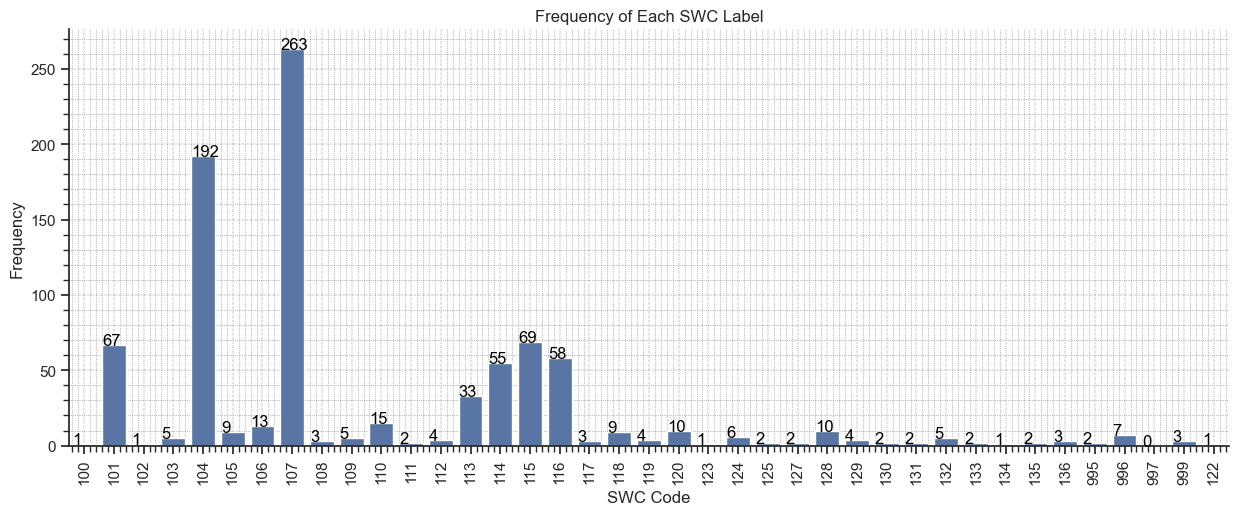

In [237]:
sns.set(style='ticks')
#create grouped bar chart

g=sns.catplot(x='SWC Code', y='Frequency', data=pd.DataFrame(data=SWC_Labels_Statistic), kind='bar', height=5, aspect=2.5)

ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0,
            p.get_height()* 1 ,
            '{0:.0f}'.format(p.get_height()),
            color='black',  size='medium')
    
plt.title('Frequency of Each SWC Label', fontsize=12)
plt.grid(True, color = "grey", which='major', linewidth = "0.3", linestyle = "-.")
plt.grid(True, color="grey", which='minor', linestyle=':', linewidth="0.5")
   
plt.xticks(rotation = 90)
plt.minorticks_on()

## **3.3. DASP Labels Frequency**
---

In [238]:
DASP_Labels_Statistic= pd.DataFrame(columns=['DASP Rank','Frequency'])
codes= cgt_MultiDS_DASP.columns.tolist()
codes.pop(0)
DASP_Labels = ['Reentrancy','Access Control','Arithmetic','Unchecked Return Values','DoS','Bad Randomness','Front-Running','Time manipulation','Short Address Attack','Unknown Unknowns']

for index in range(0, len(codes)):
    DASP_Labels_Statistic.at[index,'DASP Rank'] = DASP_Labels[index]
    DASP_Labels_Statistic.at[index,'Frequency'] = sum(cgt_MultiDS_DASP[codes[index]])
DASP_Labels_Statistic

,DASP Rank,Frequency
0,Reentrancy,263
1,Access Control,115
2,Arithmetic,70
3,Unchecked Return Values,192
4,DoS,49
5,Bad Randomness,10
6,Front-Running,55
7,Time manipulation,58
8,Short Address Attack,2
9,Unknown Unknowns,72


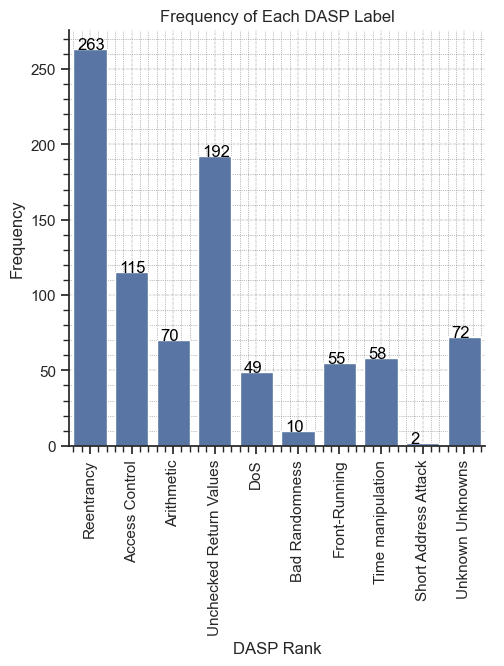

In [239]:
sns.set(style='ticks')
#create grouped bar chart

g=sns.catplot(x='DASP Rank', y='Frequency', data=pd.DataFrame(data=DASP_Labels_Statistic), kind='bar', height=5, aspect=1)

ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.1,
            p.get_height()* 1 ,
            '{0:.0f}'.format(p.get_height()),
            color='black', size='medium')
    
plt.title('Frequency of Each DASP Label', fontsize=12)
plt.grid(True, color = "grey", which='major', linewidth = "0.3", linestyle = "-.")
plt.grid(True, color="grey", which='minor', linestyle=':', linewidth="0.5")
   
plt.xticks(rotation = 90)
plt.minorticks_on()

# **4. Samples Selection**
---

## **4.1. Identify Solidity Version of Samples**
---

In [240]:
cgt_MultiDS_SolVersions = pd.DataFrame(columns=['dataset','id','fp_sol','Address','SolidityVersion'])
cgt_MultiDS_SolVersions['dataset'] = cgt_MultiDS['dataset']
cgt_MultiDS_SolVersions['id'] = cgt_MultiDS['id']
cgt_MultiDS_SolVersions['fp_sol'] = cgt_MultiDS['fp_sol']
cgt_MultiDS_SolVersions['Address'] = cgt_MultiDS['addr']
cgt_MultiDS_SolVersions

,dataset,id,fp_sol,Address,SolidityVersion
0,SolidiFI,Overflow-Underflow-3,e01ab8b006611d8612a81724edcfdc02,NaN,NaN
1,SolidiFI,Overflow-Underflow-30,acb72f1f3b2898b62d6d841f999e5c77,NaN,NaN
2,SBcurated,mishandled,914172cd9a4220f4edd2f53ac1c140fe,NaN,NaN
3,JiuZhou,byte[],f4f5521d8231f09f5145a06c6e55315f,NaN,NaN
4,SolidiFI,Overflow-Underflow-31,e42f79800a4c6a1bf6fded5cf76c5b5e,NaN,NaN
...,...,...,...,...,...
1562,eThor,0xfe3672eff595cfd36ed05aaf4622d1aec3b5e852,58e72e153b767b33fa73f3bec1735760,0xfe3672eff595cfd36ed05aaf4622d1aec3b5e852,NaN
1563,eThor,0xfe70f7d0fe6ceb71d4fc0308322ffa6098043e43,cdb8ca9da6bb4dc0c63586e46f503234,0xfe70f7d0fe6ceb71d4fc0308322ffa6098043e43,NaN
1564,eThor,0xfeeb8a968f0d7fd58e29fbfc525051f50ee2fedc,ab0e2ea9e14512594f714bc485a94361,0xfeeb8a968f0d7fd58e29fbfc525051f50ee2fedc,NaN
1565,eThor,0xff3216f86a723f2c23b03b5cd1f622eb1a204159,d2c9f4ddb6dabb91742838a31da15421,0xff3216f86a723f2c23b03b5cd1f622eb1a204159,NaN


In [241]:
def checkSolVersion(filename):
    file = open(filename,"r")
    code = file.readlines()
    file.close()
    version = ""
    for line in range(0,len(code)):
        if 'pragma' in code[line]:
            data = code[line].rstrip().rsplit(";")
            solVersion = data[0].rsplit(" ")
            version = solVersion[len(solVersion)-1]
            flag = 0
            for i in range(0, len(version)):
                if version[i].isdigit():
                    version = version[i:]
                    break
                else:
                    flag += 1
                    if len(version) == flag:
                        version = None
                        break
            break
    return(version)

In [242]:
sourcCodeFiles_Path = './cgt/source/'
notFoundIDs = []
for filename in os.listdir(sourcCodeFiles_Path):
    FP_SOL = filename.rsplit('.')[0]
    version = checkSolVersion(sourcCodeFiles_Path + filename)
    if len(cgt_MultiDS_SolVersions.query("fp_sol == @FP_SOL"))>0:
        index = cgt_MultiDS_SolVersions.query("fp_sol == @FP_SOL").index[0]
        cgt_MultiDS_SolVersions.at[index,'SolidityVersion'] = version
    else:
        notFoundIDs.append(FP_SOL)
print('%d ids are not found:' %len(notFoundIDs))
print(notFoundIDs)

1536 ids are not found:
['bf78f99f096987ca444f6a8ea28142cb', '613592ec713754ff414af093a3003ee2', '4267dc54c20681ce22869cc8bbdd4a61', '2e6bebb0982f02b00d3c5947bdde1601', '8995221fa544359e65c2c1c60c52cefa', 'a380a749e75d2a48f0fb963fa2a953d6', 'a508afc376b4adfa89f1c12f23f471f6', 'c67d5a86d2d9cde16a772e24559fee26', '6d2a2803ee6f4ec2404a40252029c180', 'fb2de87dd95f467e3d733b871c0ab169', '2333f0818c09f6c1e77878e4890b2138', '79792891790db94c2f58a87aa65ff958', '13a5bb3f51f462630818a1827e88982c', '018e9418a46c3e7cccb7975b4f3b785d', '90dc147c5c62fea93e194502776f4aea', '1a5d927054ea9dbfcc7903c503f2924a', '82ccd5367f915d111504bd7afd3a29bf', '3110941db9bf2c1d57c9000020fe4dcb', '38457d3a2f1e4678d1c2282958fa34c1', '77bd069d7e6f290da86c92a99dc9f095', '2aef3ecc1f9a9bd10c4e6c5b59c3564b', 'a54f5981c03a37a1b86e26ce5f146539', 'b37d7077feeed635bf11c21fd9da3037', 'ec8e3958c4c88f45bb61a02ef6f389ac', '1e844f3c1c41a6ef685bf2637730e6c8', '4937d757829b8e134bb0c438a3f20a4e', '3df4b22187eadb8128b1ee6d75aa649b', 'b8

In [243]:
print('Solidity version of each contract: ')
cgt_MultiDS_SolVersions

Solidity version of each contract: 


,dataset,id,fp_sol,Address,SolidityVersion
0,SolidiFI,Overflow-Underflow-3,e01ab8b006611d8612a81724edcfdc02,NaN,0.5.1
1,SolidiFI,Overflow-Underflow-30,acb72f1f3b2898b62d6d841f999e5c77,NaN,0.5.11
2,SBcurated,mishandled,914172cd9a4220f4edd2f53ac1c140fe,NaN,0.4.0
3,JiuZhou,byte[],f4f5521d8231f09f5145a06c6e55315f,NaN,0.6.2
4,SolidiFI,Overflow-Underflow-31,e42f79800a4c6a1bf6fded5cf76c5b5e,NaN,0.5.11
...,...,...,...,...,...
1562,eThor,0xfe3672eff595cfd36ed05aaf4622d1aec3b5e852,58e72e153b767b33fa73f3bec1735760,0xfe3672eff595cfd36ed05aaf4622d1aec3b5e852,
1563,eThor,0xfe70f7d0fe6ceb71d4fc0308322ffa6098043e43,cdb8ca9da6bb4dc0c63586e46f503234,0xfe70f7d0fe6ceb71d4fc0308322ffa6098043e43,
1564,eThor,0xfeeb8a968f0d7fd58e29fbfc525051f50ee2fedc,ab0e2ea9e14512594f714bc485a94361,0xfeeb8a968f0d7fd58e29fbfc525051f50ee2fedc,
1565,eThor,0xff3216f86a723f2c23b03b5cd1f622eb1a204159,d2c9f4ddb6dabb91742838a31da15421,0xff3216f86a723f2c23b03b5cd1f622eb1a204159,0.4.2


## **4.2. Frequency of SC Versions**
---

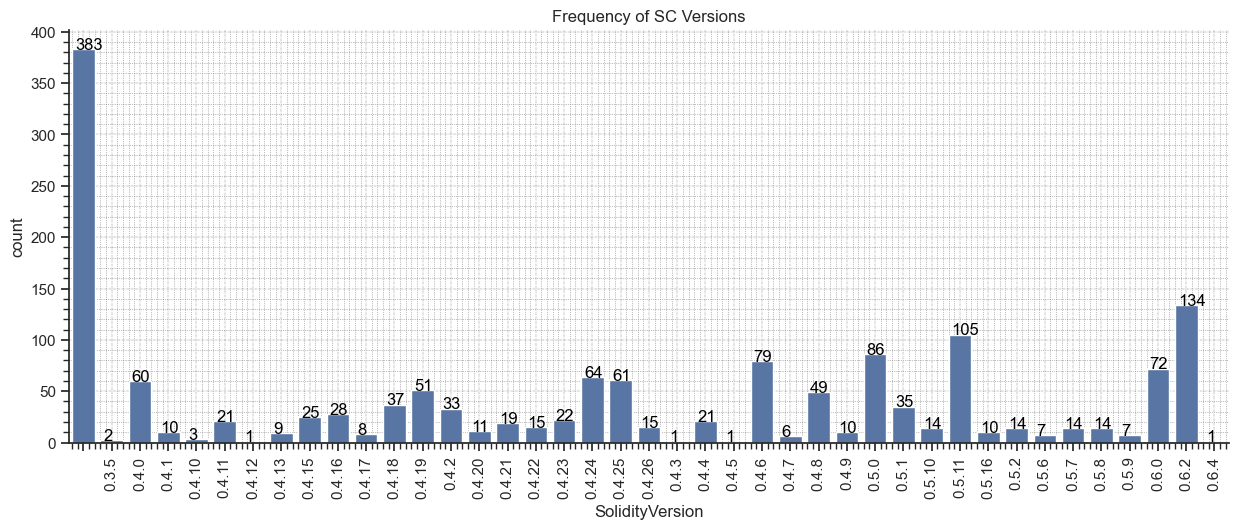

In [244]:
sns.set(style='ticks')
g=sns.catplot(x='SolidityVersion', y='count', data=pd.DataFrame(data=cgt_MultiDS_SolVersions['SolidityVersion'].value_counts().sort_index()), kind='bar', height=5, aspect=2.5)

plt.title('Frequency of SC Versions', fontsize=12)
plt.grid(True, color = "grey", which='major', linewidth = "0.3", linestyle = "-.")
plt.grid(True, color="grey", which='minor', linestyle=':', linewidth="0.5")

ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.1,
            p.get_height()* 1 ,
            '{0:.0f}'.format(p.get_height()),
            color='black',  size='medium')
    
plt.xticks(rotation = 90)
plt.minorticks_on()

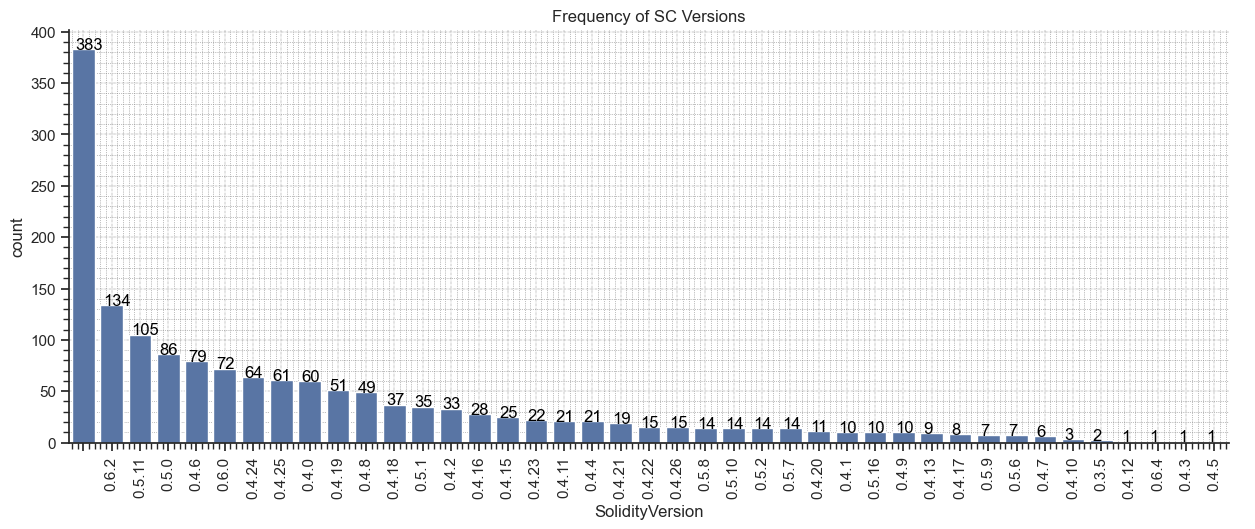

In [245]:
sns.set(style='ticks')
g=sns.catplot(x='SolidityVersion', y='count', data=pd.DataFrame(data=cgt_MultiDS_SolVersions['SolidityVersion'].value_counts()), kind='bar', height=5, aspect=2.5)

plt.title('Frequency of SC Versions', fontsize=12)
plt.grid(True, color = "grey", which='major', linewidth = "0.3", linestyle = "-.")
plt.grid(True, color="grey", which='minor', linestyle=':', linewidth="0.5")

ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.1,
            p.get_height()* 1 ,
            '{0:.0f}'.format(p.get_height()),
            color='black',  size='medium')
    
plt.xticks(rotation = 90)
plt.minorticks_on()

## **4.3. Determine the Study Sample Set**
*   **To be selected, the following conditions must be met:**
    *   Solidity version is declared, i.e. version value is not None.
    *   The solidity version is supported by current analysis tools.
        *   solc supports version 0.4.0 and above.
---

### **4.3.1. Remove unuseful samples**
---

In [246]:
cgt_MultiDS_StudySet = cgt_MultiDS_SolVersions

In [247]:
#Remove samples with None Solidity version
cgt_MultiDS_StudySet['SolidityVersion'].replace('', np.nan, inplace=True)
cgt_MultiDS_StudySet.dropna(subset=["SolidityVersion"], inplace=True)
cgt_MultiDS_StudySet.reset_index(inplace=True, drop=True)
cgt_MultiDS_StudySet

,dataset,id,fp_sol,Address,SolidityVersion
0,SolidiFI,Overflow-Underflow-3,e01ab8b006611d8612a81724edcfdc02,NaN,0.5.1
1,SolidiFI,Overflow-Underflow-30,acb72f1f3b2898b62d6d841f999e5c77,NaN,0.5.11
2,SBcurated,mishandled,914172cd9a4220f4edd2f53ac1c140fe,NaN,0.4.0
3,JiuZhou,byte[],f4f5521d8231f09f5145a06c6e55315f,NaN,0.6.2
4,SolidiFI,Overflow-Underflow-31,e42f79800a4c6a1bf6fded5cf76c5b5e,NaN,0.5.11
...,...,...,...,...,...
1170,eThor,0xf884e0096f826f82d9999dc11becb836dbb7c1f7,2ea121a615f085c42c640ebb9b3d2184,0xf884e0096f826f82d9999dc11becb836dbb7c1f7,0.4.0
1171,eThor,0xf9735dc96a98f68ac8fe6fccf1e7b9876ddb6b47,65dac7037f5d9cfbbcea9804ca0228fa,0xf9735dc96a98f68ac8fe6fccf1e7b9876ddb6b47,0.4.2
1172,eThor,0xfac50f760d114de38bf0a6d44f31a9c22f778db3,0aef6c211111272d7254889fc692314e,0xfac50f760d114de38bf0a6d44f31a9c22f778db3,0.4.8
1173,eThor,0xff3216f86a723f2c23b03b5cd1f622eb1a204159,d2c9f4ddb6dabb91742838a31da15421,0xff3216f86a723f2c23b03b5cd1f622eb1a204159,0.4.2


In [248]:
#Remove samples that use unsupported Solidity compiler versions
toBeDroped = []
for index, row in cgt_MultiDS_StudySet.iterrows():
    if int(row['SolidityVersion'][2]) < 4:
        toBeDroped.append(index)
cgt_MultiDS_StudySet=cgt_MultiDS_StudySet.drop(index= toBeDroped)
cgt_MultiDS_StudySet.reset_index(inplace=True, drop=True)
cgt_MultiDS_StudySet

,dataset,id,fp_sol,Address,SolidityVersion
0,SolidiFI,Overflow-Underflow-3,e01ab8b006611d8612a81724edcfdc02,NaN,0.5.1
1,SolidiFI,Overflow-Underflow-30,acb72f1f3b2898b62d6d841f999e5c77,NaN,0.5.11
2,SBcurated,mishandled,914172cd9a4220f4edd2f53ac1c140fe,NaN,0.4.0
3,JiuZhou,byte[],f4f5521d8231f09f5145a06c6e55315f,NaN,0.6.2
4,SolidiFI,Overflow-Underflow-31,e42f79800a4c6a1bf6fded5cf76c5b5e,NaN,0.5.11
...,...,...,...,...,...
1168,eThor,0xf884e0096f826f82d9999dc11becb836dbb7c1f7,2ea121a615f085c42c640ebb9b3d2184,0xf884e0096f826f82d9999dc11becb836dbb7c1f7,0.4.0
1169,eThor,0xf9735dc96a98f68ac8fe6fccf1e7b9876ddb6b47,65dac7037f5d9cfbbcea9804ca0228fa,0xf9735dc96a98f68ac8fe6fccf1e7b9876ddb6b47,0.4.2
1170,eThor,0xfac50f760d114de38bf0a6d44f31a9c22f778db3,0aef6c211111272d7254889fc692314e,0xfac50f760d114de38bf0a6d44f31a9c22f778db3,0.4.8
1171,eThor,0xff3216f86a723f2c23b03b5cd1f622eb1a204159,d2c9f4ddb6dabb91742838a31da15421,0xff3216f86a723f2c23b03b5cd1f622eb1a204159,0.4.2


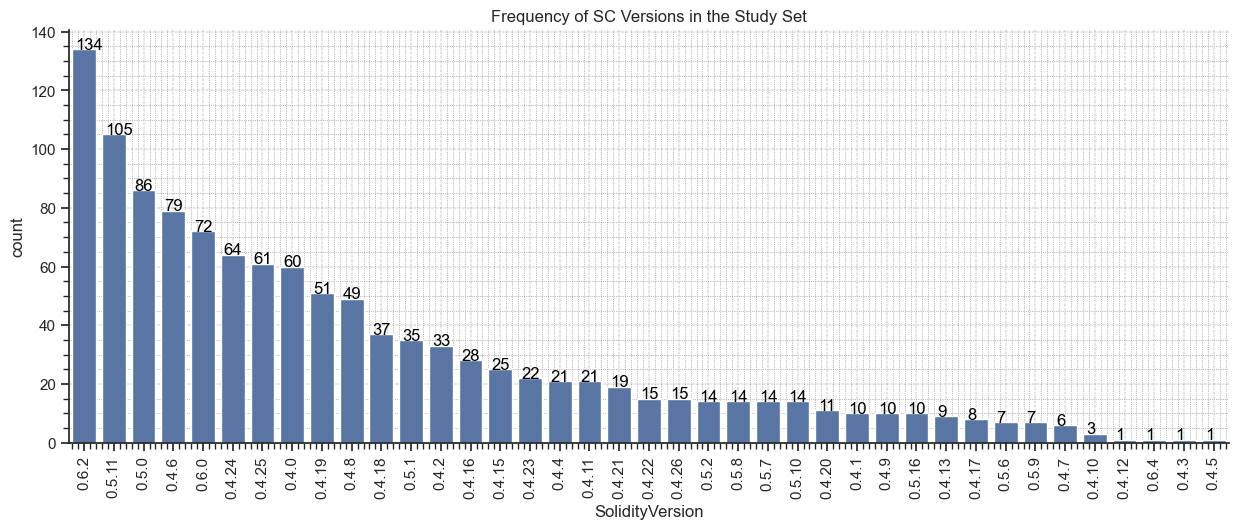

In [249]:
sns.set(style='ticks')
g=sns.catplot(x='SolidityVersion', y='count', data=pd.DataFrame(data=cgt_MultiDS_StudySet['SolidityVersion'].value_counts()), kind='bar', height=5, aspect=2.5)

plt.title('Frequency of SC Versions in the Study Set', fontsize=12)
plt.grid(True, color = "grey", which='major', linewidth = "0.3", linestyle = "-.")
plt.grid(True, color="grey", which='minor', linestyle=':', linewidth="0.5")

ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.1,
            p.get_height()* 1 ,
            '{0:.0f}'.format(p.get_height()),
            color='black',  size='medium')
    
plt.xticks(rotation = 90)
plt.minorticks_on()

### **4.3.2. Extract Source Code Files & Versions**
---

In [250]:
import shutil
files = cgt_MultiDS_StudySet['fp_sol']

for file in files:
    shutil.copy2('./cgt/source/'+file+'.sol', './Study_SamplesSet/'+file+'.sol')

In [251]:
cgt_MultiDS_StudySet = cgt_MultiDS_StudySet.reset_index(drop=True)
cgt_MultiDS_StudySet

,dataset,id,fp_sol,Address,SolidityVersion
0,SolidiFI,Overflow-Underflow-3,e01ab8b006611d8612a81724edcfdc02,NaN,0.5.1
1,SolidiFI,Overflow-Underflow-30,acb72f1f3b2898b62d6d841f999e5c77,NaN,0.5.11
2,SBcurated,mishandled,914172cd9a4220f4edd2f53ac1c140fe,NaN,0.4.0
3,JiuZhou,byte[],f4f5521d8231f09f5145a06c6e55315f,NaN,0.6.2
4,SolidiFI,Overflow-Underflow-31,e42f79800a4c6a1bf6fded5cf76c5b5e,NaN,0.5.11
...,...,...,...,...,...
1168,eThor,0xf884e0096f826f82d9999dc11becb836dbb7c1f7,2ea121a615f085c42c640ebb9b3d2184,0xf884e0096f826f82d9999dc11becb836dbb7c1f7,0.4.0
1169,eThor,0xf9735dc96a98f68ac8fe6fccf1e7b9876ddb6b47,65dac7037f5d9cfbbcea9804ca0228fa,0xf9735dc96a98f68ac8fe6fccf1e7b9876ddb6b47,0.4.2
1170,eThor,0xfac50f760d114de38bf0a6d44f31a9c22f778db3,0aef6c211111272d7254889fc692314e,0xfac50f760d114de38bf0a6d44f31a9c22f778db3,0.4.8
1171,eThor,0xff3216f86a723f2c23b03b5cd1f622eb1a204159,d2c9f4ddb6dabb91742838a31da15421,0xff3216f86a723f2c23b03b5cd1f622eb1a204159,0.4.2


In [252]:
samplesInfo = open('./Study_SamplesSet/SamplesInfo.txt','w')
for index, row in cgt_MultiDS_StudySet.iterrows():
    line = row['fp_sol'] + ':' + row['SolidityVersion']
    samplesInfo.write(line)
    if index < len(cgt_MultiDS_StudySet) - 1:
        samplesInfo.write('\n')
samplesInfo.close()

### **4.3.3. Multi-Labeled Base DS**
---

In [253]:
cgt_MultiDS_StudySet['property'] = ''
cgt_MultiDS_StudySet['SWC'] = ''
cgt_MultiDS_StudySet['DASP'] = ''

for index, row in cgt_MultiDS_StudySet.iterrows():
    currentID= row['id']
    id = cgt_MultiDS.query("id == @currentID").index[0]
    cgt_MultiDS_StudySet.at[index,'property'] = cgt_MultiDS['property'].iloc[id]
    cgt_MultiDS_StudySet.at[index,'SWC'] = cgt_MultiDS['SWC'].iloc[id]
    cgt_MultiDS_StudySet.at[index,'DASP'] = cgt_MultiDS['DASP'].iloc[id]
cgt_MultiDS_StudySet.to_csv('./EDA_Outcomes/cgt_MultiDS_StudySet.csv',index=False)
cgt_MultiDS_StudySet.to_csv('./EDA_Outcomes/TestSet.csv',index=False)
cgt_MultiDS_StudySet

,dataset,id,fp_sol,Address,SolidityVersion,property,SWC,DASP
0,SolidiFI,Overflow-Underflow-3,e01ab8b006611d8612a81724edcfdc02,NaN,0.5.1,[Overflow-Underflow],[101],[3]
1,SolidiFI,Overflow-Underflow-30,acb72f1f3b2898b62d6d841f999e5c77,NaN,0.5.11,[Overflow-Underflow],[101],[3]
2,SBcurated,mishandled,914172cd9a4220f4edd2f53ac1c140fe,NaN,0.4.0,[unchecked_low_level_calls],[104],[4]
3,JiuZhou,byte[],f4f5521d8231f09f5145a06c6e55315f,NaN,0.6.2,[byte[]],[],[10]
4,SolidiFI,Overflow-Underflow-31,e42f79800a4c6a1bf6fded5cf76c5b5e,NaN,0.5.11,[Overflow-Underflow],[101],[3]
...,...,...,...,...,...,...,...,...
1168,eThor,0xf884e0096f826f82d9999dc11becb836dbb7c1f7,2ea121a615f085c42c640ebb9b3d2184,0xf884e0096f826f82d9999dc11becb836dbb7c1f7,0.4.0,[],[],[]
1169,eThor,0xf9735dc96a98f68ac8fe6fccf1e7b9876ddb6b47,65dac7037f5d9cfbbcea9804ca0228fa,0xf9735dc96a98f68ac8fe6fccf1e7b9876ddb6b47,0.4.2,[],[],[]
1170,eThor,0xfac50f760d114de38bf0a6d44f31a9c22f778db3,0aef6c211111272d7254889fc692314e,0xfac50f760d114de38bf0a6d44f31a9c22f778db3,0.4.8,[reentrancy],[107],[1]
1171,eThor,0xff3216f86a723f2c23b03b5cd1f622eb1a204159,d2c9f4ddb6dabb91742838a31da15421,0xff3216f86a723f2c23b03b5cd1f622eb1a204159,0.4.2,[],[],[]


In [254]:
cgt_MultiDS_StudySet['dataset'].value_counts()

dataset
SolidiFI       343
Doublade       225
eThor          223
JiuZhou        164
SBcurated      101
SWCregistry     91
NotSoSmartC     26
Name: count, dtype: int64

In [255]:
datasets = cgt_MultiDS_StudySet['dataset'].unique().tolist()
datasets

['SolidiFI',
 'SBcurated',
 'JiuZhou',
 'Doublade',
 'SWCregistry',
 'NotSoSmartC',
 'eThor']

In [256]:
for DS in datasets:
    subData = cgt_MultiDS_StudySet[cgt_MultiDS_StudySet.dataset == DS]
    subData.to_csv('./EDA_Outcomes/BaseDS/' + DS +'.csv',index=False)

### **4.3.4. SWC Labeled Base DS**
---

In [257]:
cgt_MultiDS_StudySet_SWC = pd.DataFrame(columns=['id','100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '123', '124', '125', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '995', '996', '997', '999'])

for index, row in cgt_MultiDS_StudySet.iterrows():
    cgt_MultiDS_StudySet_SWC.at[index,'id'] = row['id']
    for code in row['SWC']:
        cgt_MultiDS_StudySet_SWC.at[index,str(code)] = 1
cgt_MultiDS_StudySet_SWC.fillna(0, inplace=True)
cgt_MultiDS_StudySet_SWC.to_csv('./EDA_Outcomes/cgt_MultiDS_StudySet_SWC.csv',index=False)
cgt_MultiDS_StudySet_SWC

,id,100,101,102,103,104,105,106,107,108,...,132,133,134,135,136,995,996,997,999,122
0,Overflow-Underflow-3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,Overflow-Underflow-30,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,mishandled,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,byte[],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,Overflow-Underflow-31,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,0xf884e0096f826f82d9999dc11becb836dbb7c1f7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1169,0xf9735dc96a98f68ac8fe6fccf1e7b9876ddb6b47,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1170,0xfac50f760d114de38bf0a6d44f31a9c22f778db3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.0
1171,0xff3216f86a723f2c23b03b5cd1f622eb1a204159,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


### **4.3.5. DASP Labeled Base DS**
---

In [258]:
cgt_MultiDS_StudySet_DASP = pd.DataFrame(columns=['id','1','2','3','4','5','6','7','8','9','10'])

for index, row in cgt_MultiDS_StudySet.iterrows():
    cgt_MultiDS_StudySet_DASP.at[index,'id'] = row['id']
    for code in row['DASP']:
        cgt_MultiDS_StudySet_DASP.at[index,str(code)] = 1
cgt_MultiDS_StudySet_DASP.fillna(0, inplace=True)

cgt_MultiDS_StudySet_DASP.to_csv('./EDA_Outcomes/cgt_MultiDS_StudySet_DASP.csv',index=False)
cgt_MultiDS_StudySet_DASP

,id,1,2,3,4,5,6,7,8,9,10
0,Overflow-Underflow-3,0,0,1,0,0,0,0,0,0,0
1,Overflow-Underflow-30,0,0,1,0,0,0,0,0,0,0
2,mishandled,0,0,0,1,0,0,0,0,0,0
3,byte[],0,0,0,0,0,0,0,0,0,1
4,Overflow-Underflow-31,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1168,0xf884e0096f826f82d9999dc11becb836dbb7c1f7,0,0,0,0,0,0,0,0,0,0
1169,0xf9735dc96a98f68ac8fe6fccf1e7b9876ddb6b47,0,0,0,0,0,0,0,0,0,0
1170,0xfac50f760d114de38bf0a6d44f31a9c22f778db3,1,0,0,0,0,0,0,0,0,0
1171,0xff3216f86a723f2c23b03b5cd1f622eb1a204159,0,0,0,0,0,0,0,0,0,0


### **4.3.6. DASP Labels Frequency in Base DS**
---

In [259]:
DASP_Labels_Statistic_BaseDS= pd.DataFrame(columns=['DASP Rank','Frequency'])
codes= cgt_MultiDS_StudySet_DASP.columns.tolist()
codes.pop(0)
DASP_Labels = ['Reentrancy','Access Control','Arithmetic','Unchecked Return Values','DoS','Bad Randomness','Front-Running','Time manipulation','Short Address Attack','Unknown Unknowns']

for index in range(0, len(codes)):
    DASP_Labels_Statistic_BaseDS.at[index,'DASP Rank'] = DASP_Labels[index]
    DASP_Labels_Statistic_BaseDS.at[index,'Frequency'] = sum(cgt_MultiDS_StudySet_DASP[codes[index]])
DASP_Labels_Statistic_BaseDS

,DASP Rank,Frequency
0,Reentrancy,149
1,Access Control,113
2,Arithmetic,69
3,Unchecked Return Values,180
4,DoS,48
5,Bad Randomness,7
6,Front-Running,55
7,Time manipulation,57
8,Short Address Attack,2
9,Unknown Unknowns,68


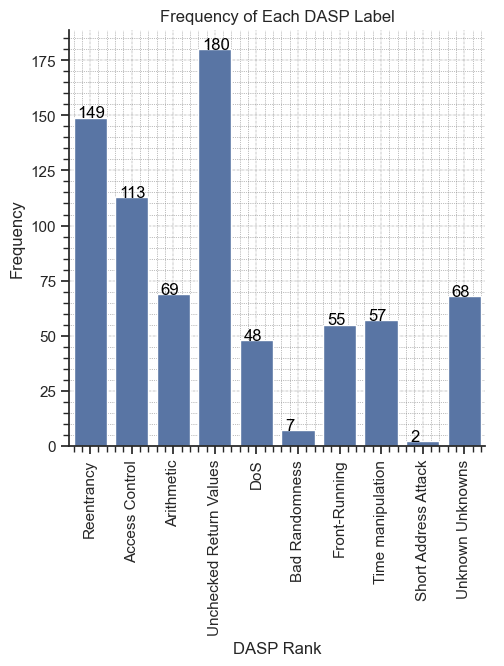

In [260]:
sns.set(style='ticks')
#create grouped bar chart

g=sns.catplot(x='DASP Rank', y='Frequency', data=pd.DataFrame(data=DASP_Labels_Statistic_BaseDS), kind='bar', height=5, aspect=1)

ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.1,
            p.get_height()* 1 ,
            '{0:.0f}'.format(p.get_height()),
            color='black', size='medium')
    
plt.title('Frequency of Each DASP Label', fontsize=12)
plt.grid(True, color = "grey", which='major', linewidth = "0.3", linestyle = "-.")
plt.grid(True, color="grey", which='minor', linestyle=':', linewidth="0.5")
   
plt.xticks(rotation = 90)
plt.minorticks_on()

### **4.3.7. Patterns Frequency per DBase**
---

In [261]:
Labels = ['Dataset Size','Positive Samples','Reentrancy','Access Control','Arithmetic','Unchecked Return Values','DoS','Bad Randomness','Front-Running','Time manipulation','Short Address Attack','Unknown Unknowns']

In [262]:
def read_DBase(DBase):
    df = pd.read_csv('./EDA_Outcomes/BaseDS/'+DBase+'.csv',converters={'DASP': literal_eval})
    return df

In [263]:
def DASP_Counts_list(DBase):
    countList =  pd.DataFrame(columns=['Total','Total Positive Samples','1','2','3','4','5','6','7','8','9','10'])
    countList.at[0,'Total'] = len(DBase)
    countList.at[0,'Total Positive Samples'] = 0
    for i in range(1,11):
        countList.at[0,str(i)] = 0

    for index, row in DBase.iterrows():
        if len(DBase.at[index,'DASP']) >= 1:
           countList.at[0,'Total Positive Samples'] =  countList.at[0,'Total Positive Samples'] + 1
           for i in range(1,11):
               countList.at[0,str(i)] =  countList.at[0,str(i)] + 1 if i in DBase.at[index,'DASP'] else countList.at[0,str(i)]
    return countList

/var/folders/9f/l2zc5y5j5zdg_clh6fyts20r0000gn/T/ipykernel_18845/275809159.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(labels=Labels, rotation=40)


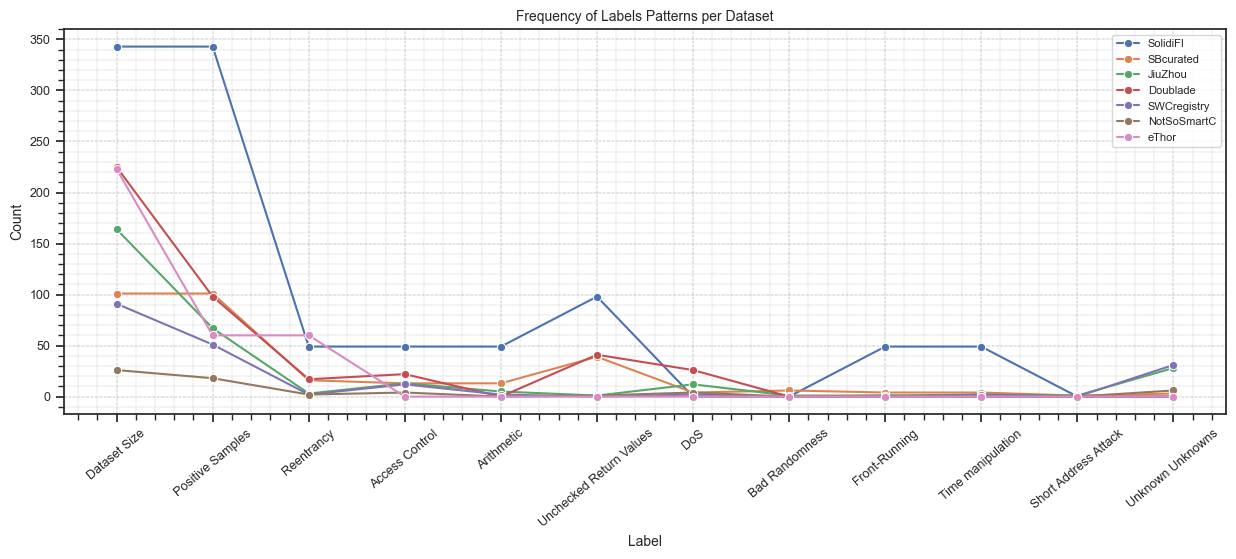

In [264]:
datasets = cgt_MultiDS_StudySet['dataset'].unique().tolist()
DS_StatisticsDF = pd.DataFrame(columns=['Dataset','Type'])
df_DASP_Counts_all = pd.DataFrame(columns=['Total','Total Positive Samples','1','2','3','4','5','6','7','8','9','10'])

sns.set(style='ticks')
fig=plt.figure(figsize=(15,5))
#plt.style.use('seaborn-v0_8-muted')
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)

for ds in datasets:
    DS_StatisticsDF.at[len(DS_StatisticsDF),'Dataset'] = ds

    df = read_DBase(ds)
    df['DASP'].value_counts()
    df_DASP_Counts = DASP_Counts_list(df)

    df_DASP_Counts_all =  pd.concat([df_DASP_Counts_all, df_DASP_Counts], axis=0)
    df_DASP_Counts_all.reset_index(inplace=True,drop=True)

    g = sns.lineplot(x=df_DASP_Counts.columns.tolist(),y=df_DASP_Counts.values.tolist()[0],label=ds,marker='o')

g.set_xticklabels(labels=Labels, rotation=40)
plt.xlabel('Label',fontsize = 10)
plt.ylabel('Count',fontsize = 10)            
plt.title('Frequency of Labels Patterns per Dataset',fontsize = 10)
plt.grid(True, color = "grey", which='major', linewidth = "0.3", linestyle = "-.")
plt.grid(True, color="grey", which='minor', linestyle=':', linewidth="0.3");
plt.legend(fontsize = 8)
plt.minorticks_on()

In [265]:
DS_StatisticsDF = pd.concat([DS_StatisticsDF, df_DASP_Counts_all], axis=1)

crafted = ['JiuZhou','NotSoSmartC','SBcurated','SolidiFI','SWCregistry']
for index, row in DS_StatisticsDF.iterrows():
    DS_StatisticsDF.at[index,'Type'] = 'Crafted' if DS_StatisticsDF.at[index,'Dataset'] in crafted else 'Wild'

DS_StatisticsDF

,Dataset,Type,Total,Total Positive Samples,1,2,3,4,5,6,7,8,9,10
0,SolidiFI,Crafted,343,343,49,49,49,98,0,0,49,49,0,0
1,SBcurated,Crafted,101,101,16,13,13,39,4,6,4,4,1,3
2,JiuZhou,Crafted,164,67,3,13,5,1,12,1,1,2,1,28
3,Doublade,Wild,225,98,17,22,0,41,26,0,0,0,0,0
4,SWCregistry,Crafted,91,51,2,12,2,0,2,0,0,2,0,31
5,NotSoSmartC,Crafted,26,18,2,4,0,1,4,0,1,0,0,6
6,eThor,Wild,223,60,60,0,0,0,0,0,0,0,0,0


In [266]:
DS_StatisticsDF[DS_StatisticsDF['Type']=='Wild']

,Dataset,Type,Total,Total Positive Samples,1,2,3,4,5,6,7,8,9,10
3,Doublade,Wild,225,98,17,22,0,41,26,0,0,0,0,0
6,eThor,Wild,223,60,60,0,0,0,0,0,0,0,0,0


In [267]:
DS_StatisticsDF[DS_StatisticsDF['Type']=='Crafted']

,Dataset,Type,Total,Total Positive Samples,1,2,3,4,5,6,7,8,9,10
0,SolidiFI,Crafted,343,343,49,49,49,98,0,0,49,49,0,0
1,SBcurated,Crafted,101,101,16,13,13,39,4,6,4,4,1,3
2,JiuZhou,Crafted,164,67,3,13,5,1,12,1,1,2,1,28
4,SWCregistry,Crafted,91,51,2,12,2,0,2,0,0,2,0,31
5,NotSoSmartC,Crafted,26,18,2,4,0,1,4,0,1,0,0,6


In [268]:
DS_StatisticsDFPlot = DS_StatisticsDF

In [269]:
DS_StatisticsDFPlot.drop(columns=['Type'],inplace=True)


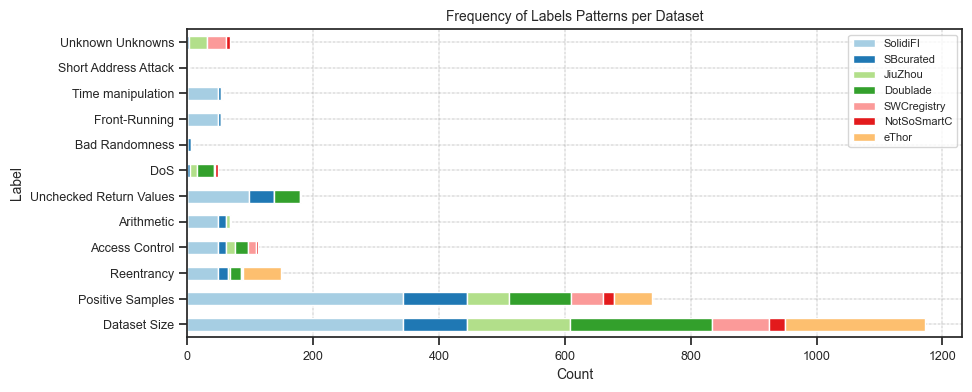

In [270]:
from matplotlib.colors import ListedColormap
colors = ['Set3','Pastel2','deep','Paired','husl','muted','GnBu_d','Blues-r','RdBu','Accent']
#sns.set(style='ticks')
#plt.style.use('seaborn-v0_8-muted')

plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)
g = DS_StatisticsDFPlot.set_index('Dataset').T.plot(kind='barh', stacked=True,figsize=(10,4),colormap=ListedColormap(sns.color_palette(colors[3], 7)))

g.set_yticklabels(labels=Labels)#, rotation=90)
plt.ylabel('Label',fontsize = 10)
plt.xlabel('Count',fontsize = 10)
plt.title('Frequency of Labels Patterns per Dataset',fontsize = 10)
plt.grid(True, color = "grey", which='major', linewidth = "0.3", linestyle = "-.")
plt.grid(True, color="grey", which='minor', linestyle=':', linewidth="0.3");
plt.legend(fontsize = 8)
#plt.minorticks_on()

# **5. Statistics on Selected DBases**
---

In [271]:
#SDBase = ['Doublade','JiuZhou','SBcurated','SolidiFI']
SDBase = slectedDSs

In [272]:
SDBase

['JiuZhou',
 'NotSoSmartC',
 'SBcurated',
 'SolidiFI',
 'SWCregistry',
 'eThor',
 'Doublade']

In [273]:
def read_DBase(DBase):
    df = pd.read_csv('./EDA_Outcomes/BaseDS/'+DBase+'.csv',converters={'DASP': literal_eval})
    return df

In [274]:
def DASP_Counts_list(DBase):
    countList =  pd.DataFrame(columns=['Total','Total Positive Samples','1','2','3','4','5','6','7','8','9','10'])
    countList.at[0,'Total'] = len(DBase)
    countList.at[0,'Total Positive Samples'] = 0
    for i in range(1,11):
        countList.at[0,str(i)] = 0

    for index, row in DBase.iterrows():
        if len(DBase.at[index,'DASP']) >= 1:
           countList.at[0,'Total Positive Samples'] =  countList.at[0,'Total Positive Samples'] + 1
           for i in range(1,11):
               countList.at[0,str(i)] =  countList.at[0,str(i)] + 1 if i in DBase.at[index,'DASP'] else countList.at[0,str(i)]
    return countList

## **5.1. Value Counts**
---

In [275]:
Doublade = read_DBase(SDBase[0])
Doublade['DASP'].value_counts()
Doublade_DASP_Counts = DASP_Counts_list(Doublade)
Doublade_DASP_Counts

,Total,Total Positive Samples,1,2,3,4,5,6,7,8,9,10
0,164,67,3,13,5,1,12,1,1,2,1,28


In [276]:
JiuZhou = read_DBase(SDBase[1])
JiuZhou['DASP'].value_counts()
JiuZhou_DASP_Counts = DASP_Counts_list(JiuZhou)
JiuZhou_DASP_Counts

,Total,Total Positive Samples,1,2,3,4,5,6,7,8,9,10
0,26,18,2,4,0,1,4,0,1,0,0,6


In [277]:
NotSoSmartC = read_DBase(SDBase[2])
NotSoSmartC['DASP'].value_counts()
NotSoSmartC_DASP_Counts = DASP_Counts_list(NotSoSmartC)
NotSoSmartC_DASP_Counts

,Total,Total Positive Samples,1,2,3,4,5,6,7,8,9,10
0,101,101,16,13,13,39,4,6,4,4,1,3


In [278]:
SBcurated = read_DBase(SDBase[3])
SBcurated['DASP'].value_counts()
SBcurated_DASP_Counts = DASP_Counts_list(SBcurated)
SBcurated_DASP_Counts

,Total,Total Positive Samples,1,2,3,4,5,6,7,8,9,10
0,343,343,49,49,49,98,0,0,49,49,0,0


In [279]:
SWCregistry = read_DBase(SDBase[4])
SWCregistry['DASP'].value_counts()
SWCregistry_DASP_Counts = DASP_Counts_list(SWCregistry)
SWCregistry_DASP_Counts

,Total,Total Positive Samples,1,2,3,4,5,6,7,8,9,10
0,91,51,2,12,2,0,2,0,0,2,0,31


In [280]:
SolidiFI = read_DBase(SDBase[5])
SolidiFI['DASP'].value_counts()
SolidiFI_DASP_Counts = DASP_Counts_list(SolidiFI)
SolidiFI_DASP_Counts

,Total,Total Positive Samples,1,2,3,4,5,6,7,8,9,10
0,223,60,60,0,0,0,0,0,0,0,0,0


In [281]:
eThor = read_DBase(SDBase[6])
eThor['DASP'].value_counts()
eThor_DASP_Counts = DASP_Counts_list(eThor)
eThor_DASP_Counts

,Total,Total Positive Samples,1,2,3,4,5,6,7,8,9,10
0,225,98,17,22,0,41,26,0,0,0,0,0


## **5.2. Patterns Frequency per DBase**
---

### **5.2.1. Plotting Data Preparation**
---

In [282]:
countsData = Doublade_DASP_Counts.values.tolist()[0] + JiuZhou_DASP_Counts.values.tolist()[0] + NotSoSmartC_DASP_Counts.values.tolist()[0] + SBcurated_DASP_Counts.values.tolist()[0] + SWCregistry_DASP_Counts.values.tolist()[0]+ SolidiFI_DASP_Counts.values.tolist()[0] + eThor_DASP_Counts.values.tolist()[0]
len(countsData)

84

In [283]:
Labels = ['Dataset Size','Positive Samples','Reentrancy','Access Control','Arithmetic','Unchecked Return Values','DoS','Bad Randomness','Front-Running','Time manipulation','Short Address Attack','Unknown Unknowns']

In [284]:
#create DataFrame
CountsDataDF_DF = pd.DataFrame({'Vulnerability': Labels*7,
                                  'Counts': countsData,
                                  'Benchmarks': ['Doublade']*12 + ['JiuZhou']*12 + ['NotSoSmartC']*12 + ['SBcurated']*12 + ['SWCregistry']*12 + ['SolidiFI']*12 + ['eThor']*12})

### **5.2.2. Data Plotting**
---

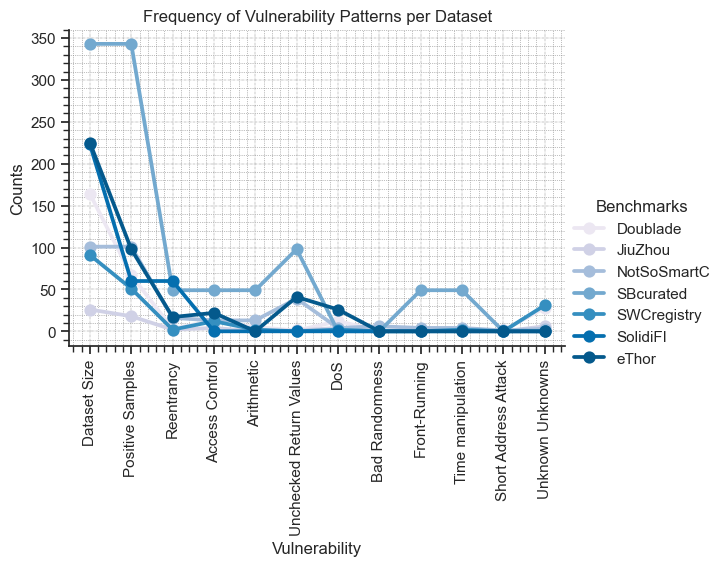

In [285]:
#set seaborn plotting aesthetics
sns.set(style='ticks')
#create grouped bar chart
g=sns.catplot(x='Vulnerability', y='Counts', hue='Benchmarks', data=CountsDataDF_DF, kind='point', height=4, aspect=1.5,palette="PuBu")

'''ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + p.get_height(),
            p.get_height()* 1,
            '{0:.0f}'.format(p.get_height()),
            color='black', rotation='vertical', size='medium')'''

plt.title('Frequency of Vulnerability Patterns per Dataset', fontsize=12)
plt.grid(True, color = "grey", which='major', linewidth = "0.3", linestyle = "-.")
plt.grid(True, color="grey", which='minor', linestyle=':', linewidth="0.5");
plt.xticks(rotation = 90)
plt.minorticks_on()

#plt.savefig('path')